Modified from https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

## Train/Validation Set split

In [5]:
from sklearn.model_selection import train_test_split

# TODO: dropna and duplicates checking

# Remove missing values and duplicates from training data
# df.drop_duplicates(inplace=True)
# df.dropna(inplace=True)

df_train = pd.read_csv('../input/train.csv')

df_train, df_validate = train_test_split(df_train, test_size = 0.2)

## Clean text

In [6]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from string import punctuation
stopword = stopwords.words('english')
stopword.extend(punctuation)
stopword = set(stopword)

stemmer = PorterStemmer()
def text_to_wordlist(text):
    text = str(text)
    text = text.lower()

    words = word_tokenize(text)
    words = [stemmer.stem(w) for w in words if not w in stopword]
    
    return words

# Word Share Model

In [7]:
def word_match_share(row):
    q1_words = set(text_to_wordlist(row['question1']))
    q2_words = set(text_to_wordlist(row['question2']))
    if len(q1_words) == 0 and len(q2_words) == 0:
        return 0
    # set intersection with &
    return len(q1_words & q2_words)/(len(q1_words) + len(q2_words))

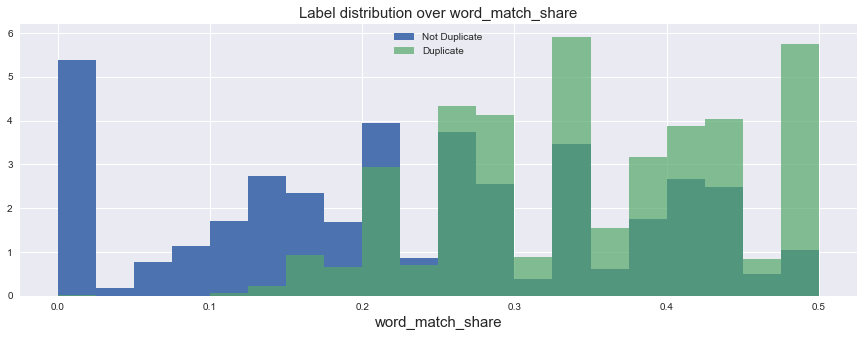

In [8]:
plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

## Calculate Log Loss 
Taken from https://www.kaggle.com/tj2552/similarity-techniques-nlp

In [9]:
from sklearn.metrics import log_loss

def calculate_logloss(y_true, y_pred):
    loss_cal = log_loss(y_true, y_pred)
    return loss_cal

In [10]:
y_true = df_validate.is_duplicate.tolist()
y_pred_word_count_match = df_validate.apply(word_match_share, axis=1, raw=True)
logloss = calculate_logloss(y_true, y_pred_word_count_match)
print ("Log loss on the validation set for word count match is %f" %logloss)

Log loss on the validation set for word count match is 0.581821


## TF-IDF with Latent Semantic Indexing

Inspired by http://www.52nlp.cn/%E5%A6%82%E4%BD%95%E8%AE%A1%E7%AE%97%E4%B8%A4%E4%B8%AA%E6%96%87%E6%A1%A3%E7%9A%84%E7%9B%B8%E4%BC%BC%E5%BA%A6%E4%B8%89

Train a LSI based on the TFIDF on the training set.

Then represent each question with the LSI as a vector. Calculate the cosine similarity of the two vectors. Use the similarity as an input for XGBoost.

In [11]:
from gensim import corpora, models

def get_corpus(df):
    texts = []
    for index, row in df_train.iterrows():
        q1_words = text_to_wordlist(row['question1'])
        q2_words = text_to_wordlist(row['question2'])
        texts.append(q1_words)
        texts.append(q2_words)
    return texts

texts = get_corpus(df_train)
dictionary = corpora.Dictionary(texts)

In [12]:
dictionary.filter_extremes(no_below = 5)

## Train LSI model based on TFIDF
Set topic number as 10 as a starting point.

In [13]:
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]


In [14]:
NUM_TOPICS = 100
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=NUM_TOPICS)

In [15]:
from sklearn.metrics.pairwise import cosine_similarity as cs

def get_lsi_vector(bow, n_dim):
    v = [0 for i in range(n_dim)]
    for index, score in lsi[bow]:
        v[index] = score
    return v

def get_similarity(row, n_dim=NUM_TOPICS):
    q1_words = text_to_wordlist(row['question1'])
    q2_words = text_to_wordlist(row['question2'])

    q1_bow = dictionary.doc2bow(q1_words)
    q2_bow = dictionary.doc2bow(q2_words)
    
    q1_lsi = get_lsi_vector(q1_bow, NUM_TOPICS)
    q2_lsi = get_lsi_vector(q2_bow, NUM_TOPICS)

    if len(q1_lsi) == 0 or len(q2_lsi) == 0:
        return 0
    return cs(np.asarray(q1_lsi).reshape(1, -1), np.asarray(q2_lsi).reshape(1, -1))[0][0]

In [16]:
y_true = df_validate.is_duplicate.tolist()
y_pred_lsi_cosine = df_validate.apply(get_similarity, axis=1, raw=True)
logloss = calculate_logloss(y_true, y_pred_lsi_cosine)
print ("Log loss on the validation set for lsi cosine similarity is %f" %logloss)

Log loss on the validation set for lsi cosine similarity is 2.227868


## XGBoost

In [17]:
# First we create our training and testing data
x_train = pd.DataFrame()
x_train['word_match'] = train_word_match
x_train['lsi_cos_similarity'] = df_train.apply(get_similarity, axis=1, raw=True)
y_train = df_train['is_duplicate'].values

x_valid = pd.DataFrame()
x_valid['word_match'] = y_pred_word_count_match
x_valid['lsi_cos_similarity'] = y_pred_lsi_cosine
y_valid = df_validate['is_duplicate'].values


In [18]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 600, watchlist, early_stopping_rounds=50, verbose_eval=10)

/Users/xiaoxli/anaconda2/envs/kaggle-question-pair.venv/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[0]	train-logloss:0.687881	valid-logloss:0.687904
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.644831	valid-logloss:0.645127
[20]	train-logloss:0.614532	valid-logloss:0.615044
[30]	train-logloss:0.59239	valid-logloss:0.593074
[40]	train-logloss:0.575698	valid-logloss:0.576533
[50]	train-logloss:0.563192	valid-logloss:0.56415
[60]	train-logloss:0.553578	valid-logloss:0.55463
[70]	train-logloss:0.546068	valid-logloss:0.547197
[80]	train-logloss:0.540179	valid-logloss:0.541367
[90]	train-logloss:0.535424	valid-logloss:0.536679
[100]	train-logloss:0.531646	valid-logloss:0.532961
[110]	train-logloss:0.528644	valid-logloss:0.530021
[120]	train-logloss:0.526241	valid-logloss:0.527679
[130]	train-logloss:0.524338	valid-logloss:0.525833
[140]	train-logloss:0.522837	valid-logloss:0.524371
[150]	train-logloss:0.521589	valid-logloss:0.523189
[160]	train-logloss:0.520593	va

## Make the Submission

Gives 0.47896 log loss on the test set

In [19]:
df_test = pd.read_csv('../input/test.csv')

x_test = pd.DataFrame()
x_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)


In [20]:
x_test['lsi_cos_similarity'] = df_test.apply(get_similarity, axis=1, raw=True)
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('simple_xgb.csv', index=False)